In [1]:
# The MIT License (MIT) Copyright (c) 2023 milmor
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Image Captioning Transformer

- This notebook explores the combination of Transformers and CNNs for image captioning, showcasing their remarkable ability to generate descriptive textual captions based on visual content.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import tensorflow_datasets as tfds
import numpy as np
import os
import re
import string
import time

In [3]:
dataset_name = "caltech_birds2011"
image_size = 128
padding = 0.25
batch_size = 64
maxlen = 36

## 1.- Pipeline

- Image captions from: https://github.com/reedscot/cvpr2016

In [4]:
def round_to_int(float_value):
    return tf.cast(tf.math.round(float_value), dtype=tf.int32)

def preprocess_image(data):
    # unnormalize bounding box coordinates
    height = tf.cast(tf.shape(data["image"])[0], dtype=tf.float32)
    width = tf.cast(tf.shape(data["image"])[1], dtype=tf.float32)
    bounding_box = data["bbox"] * tf.stack([height, width, height, width])

    # calculate center and length of longer side, add padding
    target_center_y = 0.5 * (bounding_box[0] + bounding_box[2])
    target_center_x = 0.5 * (bounding_box[1] + bounding_box[3])
    target_size = tf.maximum(
        (1.0 + padding) * (bounding_box[2] - bounding_box[0]),
        (1.0 + padding) * (bounding_box[3] - bounding_box[1]),
    )

    # modify crop size to fit into image
    target_height = tf.reduce_min(
        [target_size, 2.0 * target_center_y, 2.0 * (height - target_center_y)]
    )
    target_width = tf.reduce_min(
        [target_size, 2.0 * target_center_x, 2.0 * (width - target_center_x)]
    )

    # crop image
    image = tf.image.crop_to_bounding_box(
        data["image"],
        offset_height=round_to_int(target_center_y - 0.5 * target_height),
        offset_width=round_to_int(target_center_x - 0.5 * target_width),
        target_height=round_to_int(target_height),
        target_width=round_to_int(target_width),
    )

    # resize and clip
    # for image downsampling, area interpolation is the preferred method
    image = tf.image.resize(
        image, size=[image_size, image_size], method=tf.image.ResizeMethod.AREA
    )
    
    # replace directory path
    paths = tf.strings.regex_replace(data["image/filename"], 
                                     'CUB_200_2011/images/', 'text_c10/text/')
    
    # change file extension from .jpg to .txt
    paths = tf.strings.regex_replace(paths, '.jpg', '.txt')
    # read file
    file = tf.io.read_file(paths)
    lines = tf.strings.split(file, sep='\n')

    # access the first line (assuming it contains the desired text)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0), lines[0]

In [5]:
raw_train = tfds.load(dataset_name, split='train', shuffle_files=True)
raw_train = raw_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
raw_train = raw_train.shuffle(6000).batch(batch_size, drop_remainder=True)
raw_train = raw_train.prefetch(buffer_size=tf.data.AUTOTUNE)

raw_val = tfds.load(dataset_name, split='test')
raw_val = raw_val.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
raw_val = raw_val.batch(batch_size, drop_remainder=True)
raw_val = raw_val.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
img_batch, txt_batch = next(iter(raw_train))

In [7]:
img_batch.shape, txt_batch.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64]))

In [8]:
import matplotlib.pyplot as plt

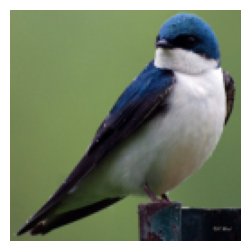

In [9]:
image_array = img_batch[0].numpy()

fig = plt.figure(figsize=(3, 3))  

# Plot the image
plt.imshow(image_array)
plt.axis('off')  # Optional: Turn off axes
plt.show()

In [10]:
txt_batch[0].numpy()

b'this bird has a black and blue back and wings with a white breast and predominately blue head.'

- Create vocabulary and tokenizer.

In [11]:
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
    return s

vocab_size = 10000
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=standardize,
    output_sequence_length=maxlen + 1)

vectorize_layer.adapt(raw_train.map(lambda img, txt: txt))

In [12]:
def preprocess(img, text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return img, x, y

train_ds = raw_train.map(preprocess)
val_ds = raw_val.map(preprocess)

In [13]:
img_batch, inp_batch, tar_batch = next(iter(train_ds))

In [14]:
img_batch.shape, inp_batch.shape, tar_batch.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 36]), TensorShape([64, 36]))

In [15]:
len(train_ds) * batch_size, len(val_ds) * batch_size

(5952, 5760)

## 2.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [16]:
class downBlock(tf.keras.models.Model):
    def __init__(self, filters, kernel_size=3, strides=2, 
                 initializer='glorot_uniform'):
        super(downBlock, self).__init__()
        self.main = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=kernel_size, 
                padding='same', kernel_initializer=initializer,
                strides=strides, use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
        ])
        
        self.direct = tf.keras.Sequential([
           layers.AveragePooling2D(pool_size=(strides, strides)),
            layers.Conv2D(filters, kernel_size=1, 
                padding='same', kernel_initializer=initializer,
                strides=1, use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2)
        ])
        
    def call(self, x):
        return (self.main(x) + self.direct(x)) / 2
    
    
downBlock(64, 8, 2)(tf.ones([32, 32, 32, 32])).shape

TensorShape([32, 16, 16, 64])

In [17]:
class CNN(layers.Layer):
    def __init__(self, model_dim):
        super(CNN, self).__init__()
        self.model_dim = model_dim
        self.aug = tf.keras.Sequential([
          layers.RandomFlip("horizontal_and_vertical"),
          layers.RandomRotation(0.2),
        ])
        
        self.conv = tf.keras.Sequential([
            layers.Conv2D(model_dim // 8, kernel_size=3, strides=2, 
                use_bias=False, padding='same'),
            layers.LeakyReLU(0.2),
            downBlock(model_dim // 8, kernel_size=3, strides=2),
            downBlock(model_dim // 4, kernel_size=3, strides=2),
            downBlock(model_dim // 2, kernel_size=3, strides=2),
            #downBlock(model_dim, kernel_size=3, strides=2),
            layers.Conv2D(model_dim, kernel_size=3, strides=1, 
                use_bias=False, padding='valid'),
            layers.LeakyReLU(0.2)
        ])   


    def call(self, x):  
        B = x.shape[0]
        x = self.aug(x)
        x = self.conv(x)
        x = tf.reshape(x, [B, -1, self.model_dim])
        return x
    
    
emb_dim = 128
test_cnn = CNN(emb_dim)
cnn_out = test_cnn(img_batch)
cnn_out.shape

TensorShape([64, 36, 128])

### Transformer block

In [18]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, model_dim, n_heads, rate=0.1, initializer='glorot_uniform'):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.model_dim = model_dim

        assert model_dim % self.n_heads == 0

        self.head_dim = model_dim // self.n_heads

        self.wq = layers.Dense(model_dim, kernel_initializer=initializer)
        self.wk = layers.Dense(model_dim, kernel_initializer=initializer)
        self.wv = layers.Dense(model_dim, kernel_initializer=initializer)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
        self.wo = layers.Dense(model_dim, kernel_initializer=initializer)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k)  
        v = self.wv(v)  

        q = self.split_heads(q, batch_size) 
        k = self.split_heads(k, batch_size)  
        v = self.split_heads(v, batch_size) 

        dh = tf.cast(self.head_dim, tf.float32)
        qk = tf.matmul(q, k, transpose_b=True)
        scaled_qk =  qk / tf.math.sqrt(dh)
        
        if mask is not None:
            scaled_qk += (mask * -1e9) 

        attn = self.dropout1(tf.nn.softmax(scaled_qk, axis=-1))
        attn = tf.matmul(attn, v) 

        attn = tf.transpose(attn, perm=[0, 2, 1, 3]) 
        original_size_attention = tf.reshape(attn, (batch_size, -1, self.model_dim)) 

        output = self.dropout2(self.wo(original_size_attention))
        return output

In [19]:
class DecoderBlock(layers.Layer):
    def __init__(self, model_dim, n_heads=2, mlp_dim=512, 
                 rate=0.0, initializer='glorot_uniform', eps=1e-6):
        super(DecoderBlock, self).__init__()
        self.attn = MultiHeadAttention(model_dim, n_heads)
        self.cross_attn = MultiHeadAttention(model_dim, n_heads)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='gelu'), 
            layers.Dense(model_dim),
            layers.Dropout(rate)
        ])
        self.ln1 = layers.LayerNormalization(epsilon=eps)
        self.ln2 = layers.LayerNormalization(epsilon=eps)
        self.ln3 = layers.LayerNormalization(epsilon=eps)
        self.drop1 = layers.Dropout(rate)
        self.drop2 = layers.Dropout(rate)

    def call(self, inputs, context, mask, training):  
        x = self.drop1(self.attn(inputs, inputs, inputs, mask), 
                       training=training) 
        skip1 = self.ln1(x + inputs)
        
        x = self.drop2(self.cross_attn(skip1, context, context), 
                       training=training) 
        skip2 = self.ln2(x + skip1)
               
        return self.ln3(self.mlp(skip2) + skip2)
    
    
emb_dim = 128
test_dec = tf.ones([batch_size, maxlen, emb_dim])
test_layer = DecoderBlock(emb_dim)
test_layer(test_dec, cnn_out, None).shape

TensorShape([64, 36, 128])

In [20]:
class TokenEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emb_dim, 
                 rate=0.1, initializer='glorot_uniform'):
        super(TokenEmbedding, self).__init__()
        self.max_len = maxlen
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=emb_dim, 
            embeddings_initializer=initializer)
        self.position_emb = layers.Embedding(
            input_dim=maxlen, output_dim=emb_dim, 
            embeddings_initializer=initializer)
        self.dropout = layers.Dropout(rate)

    def call(self, x):
        token_embeddings = self.token_emb(x)
        positions = tf.range(start=0, limit=self.max_len, delta=1)
        positions = self.position_emb(positions)
        return self.dropout(token_embeddings + positions) 

### Transformer

In [21]:
class Transformer(tf.keras.models.Model):
    def __init__(self, vocab_size=20000, maxlen=512, 
                 emb_dim=256, heads=4, mlp_dim=128, depth=3, 
                 rate=0.2, initializer='glorot_uniform', 
                 embedding_initializer='glorot_uniform', eps=1e-6,
                 mlp_activation='gelu'):
        super(Transformer, self).__init__()
        self.depth = depth
        self.tok_emb = TokenEmbedding(maxlen, vocab_size, 
                        emb_dim, rate=rate, initializer=embedding_initializer)
        self.drop = layers.Dropout(rate)
            
        self.decoder = [DecoderBlock(emb_dim, 
                                heads, mlp_dim, rate=rate,
                                initializer=initializer, eps=eps)
                            for _ in range(depth)]

        self.layernorm = layers.LayerNormalization(epsilon=eps)
        self.out = layers.Dense(vocab_size, kernel_initializer=initializer)
        self.cnn = CNN(emb_dim)
        
    def get_padding_mask(self, seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        # add extra dimensions to add the padding
        # to the attention logits.
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    def get_attention_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)
    
    def create_mask(self, x):
        attn_mask = self.get_attention_mask(tf.shape(x)[1])
        padding_mask = self.get_padding_mask(x)
        attn_mask = tf.maximum(padding_mask, attn_mask)
        return attn_mask
                       
    def call(self, x, context):
        context = self.cnn(context)
        mask = self.create_mask(x)
 
        x = self.tok_emb(x)
        x = self.drop(x)

        for i in range(self.depth):
            x = self.decoder[i](x, context, mask)

        x = self.layernorm(x)
        x = self.out(x)
        return x
       
        
emb_dim = 128
depth = 3
mlp_dim = 256

transformer = Transformer(maxlen=maxlen, vocab_size=vocab_size, emb_dim=emb_dim,
            mlp_dim=mlp_dim, depth=depth)
out = transformer(inp_batch, img_batch)
out.shape

TensorShape([64, 36, 10000])

In [22]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_embedding (TokenEmbed  multiple                 1284608   
 ding)                                                           
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 decoder_block_1 (DecoderBlo  multiple                 198784    
 ck)                                                             
                                                                 
 decoder_block_2 (DecoderBlo  multiple                 198784    
 ck)                                                             
                                                                 
 decoder_block_3 (DecoderBlo  multiple                 198784    
 ck)                                                   

## 3.- Training

In [23]:
optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.999)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [24]:
def loss_function(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

In [25]:
@tf.function
def train_step(context, inp, tar):
    with tf.GradientTape() as tape:
        pred = transformer(inp, context, training=True)
        loss = loss_function(tar, pred)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    
@tf.function
def test_step(context, inp, tar):
    pred = transformer(inp, context, training=False)
    loss = loss_function(tar, pred)
    test_loss(loss)

In [26]:
ids_to_text = tf.keras.layers.StringLookup(
                vocabulary=vectorize_layer.get_vocabulary(),
                mask_token='',
                invert=True)

In [27]:
def generate_caption(model, context, maxlen):  
    x = vectorize_layer(['[START]'])[:, :1]
    x = tf.cast(x, tf.int32)
    # Generate new text by sampling from the model
    for i in range(x.shape[1], maxlen):
        # Pad the input sequence to seq_len
        x_pad = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen, padding="post")
        # Generate logits from the model
        logits = model(x_pad, context, training=False)

        pred_index = tf.argmax(logits[:, i-1, :], axis=-1, 
                               output_type=tf.dtypes.int32)
        pred_index = pred_index[tf.newaxis]
        if ids_to_text(pred_index) == '[END]':
            break
        # Concatenate the new token to the sequence
        x = tf.concat([x, pred_index], axis=-1)

    str_list = ids_to_text(x)[0].numpy()
    text = ' '.join([s.decode('utf-8') for s in str_list[1:]])
    return text

In [28]:
img_val, txt_val = next(iter(raw_val))

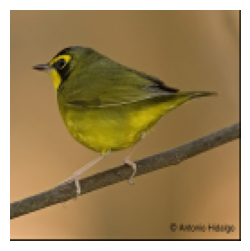

In [29]:
image_array = img_val[0].numpy()

fig = plt.figure(figsize=(3, 3))  

# Plot the image
plt.imshow(image_array)
plt.axis('off')  # Optional: Turn off axes
plt.show()

In [30]:
txt_val[0].numpy()

b'a small bird has a small black bill, a black cheek patch, and a bright yellow superciliary with a yellow belly.'

In [31]:
epochs = 15

for epoch in range(1, epochs):
    start = time.time()
    train_loss.reset_states()
    test_loss.reset_states()
    for (batch, (context, inp, tar)) in enumerate(train_ds):
        train_step(context, inp, tar)
        
    print(f'\nTime taken for epoch {epoch} is: {time.time() - start:.2f} secs', end=' ')
    print(f'Train loss: {train_loss.result():.4f}')
    
    for (batch, (context, inp, tar)) in enumerate(val_ds):
        test_step(context, inp, tar)
    print(f'Test loss: {test_loss.result():.4f}')
        
    caption = generate_caption(transformer, img_val[:1], maxlen)
    print(caption)


Time taken for epoch 1 is: 19.08 secs Train loss: 4.9989
Test loss: 3.8137
this bird has a a a a a a a a a a a a a a a and a a a a a a a a a and a and a and a and

Time taken for epoch 2 is: 3.66 secs Train loss: 3.4670
Test loss: 3.1566
this bird has a white belly and a white belly and a white beak

Time taken for epoch 3 is: 3.16 secs Train loss: 3.0886
Test loss: 2.9575
this bird has a white belly and a black belly with a black crown and a black crown

Time taken for epoch 4 is: 3.25 secs Train loss: 2.9164
Test loss: 2.8424
this bird has a white belly and a black crown

Time taken for epoch 5 is: 2.89 secs Train loss: 2.7901
Test loss: 2.7522
this bird has a white belly and belly with a black crown and a black crown

Time taken for epoch 6 is: 3.18 secs Train loss: 2.6979
Test loss: 2.6868
this bird has a white belly and belly with a black crown and a black crown

Time taken for epoch 7 is: 3.03 secs Train loss: 2.6199
Test loss: 2.6452
this bird has a yellow belly and breast with

- Test the model on validation images.

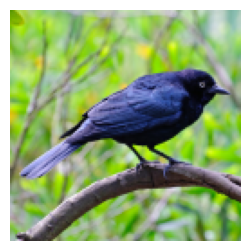

In [32]:
image_array = img_val[7].numpy()

fig = plt.figure(figsize=(3, 3))  

# Plot the image
plt.imshow(image_array)
plt.axis('off')  # Optional: Turn off axes
plt.show()

In [33]:
txt_val[7].numpy()

b'an all black bird with a relatively long tail and a bright white eyes.'

In [34]:
text = generate_caption(transformer, img_val[7:8], maxlen)
print(text)

this bird has a black head and breast with a black crown and a white belly
